In [1]:
#Check if dataset loads

import csv
import os
import numpy as np
import cv2
DATASET_PATH = "../../data/udacity_sim_data"

def load_dataset(file_path):
    '''
    Loads dataset in memory
    '''
    dataset = []
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            try:
                dataset.append({'center':line[0], 'left':line[1], 'right':line[2], 'steering':float(line[3]), 
                            'throttle':float(line[4]), 'brake':float(line[5]), 'speed':float(line[6])})
            except:
                continue
    return dataset

dataset = load_dataset(os.path.join(DATASET_PATH, "driving_log.csv"))
print("Loaded {} samples from file {}".format(len(dataset),DATASET_PATH))

Loaded 45999 samples from file ../../data/udacity_sim_data



Exploring the dataset ...


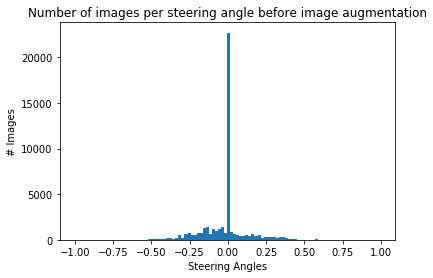

Exploring the dataset complete.


In [2]:
# Plot data distribution

import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(dataset, title, num_bins=100):
    steerings = []
    for item in dataset:
        steerings.append( float(item['steering']) )
    plot_steering_histogram(steerings, title, num_bins)
 
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(dataset, 'Number of images per steering angle before image augmentation', num_bins=100)
print("Exploring the dataset complete.")

In [3]:
# Extract features from CNN

from keras.models import load_model, Model
from keras.models import model_from_json
from tqdm import tqdm

MODEL_PATH = "../../data/weights/steer_only/model.json"

def model_layer_output(model, layer_name, image_file):
    test_model = Model(input=model.input, output=model.get_layer(layer_name).output)

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = np.asarray(image)
    image_array = image_array[None, :, :, :]

    flat_feature = test_model.predict(image_array, batch_size=50)

    return flat_feature

with open(MODEL_PATH, 'r') as jfile:
    model = model_from_json(jfile.read())

model.compile("adam", "mse")
weights_file = MODEL_PATH.replace('json', 'h5')
model.load_weights(weights_file)


steering_angle_set = []
input_feature_set = []
speed_set = []
for instant in tqdm(dataset, total=len(dataset)):
    steering_angle_set.append(instant["steering"])
    speed_set.append(instant["speed"])
    image_file = os.path.join(DATASET_PATH, instant["center"].strip())
    feature = model_layer_output(model, 'FC2', image_file)
    input_feature_set.append(feature)

steering_angle_set = np.array(steering_angle_set)
input_feature_set = np.array(input_feature_set)
speed_set = np.array(speed_set)

print(steering_angle_set.shape)
print(input_feature_set.shape)
print(speed_set.shape)

Using TensorFlow backend.
100%|██████████| 45999/45999 [00:00<00:00, 1643150.39it/s]

(45999,)
(45999,)


In [4]:
np.save("features.npy", input_feature_set)
np.save("steering.npy", steering_angle_set)
np.save("speed.npy", speed_set)

In [12]:
input_feature_set = np.load("features.npy")
steering_angle_set = np.load("steering.npy")
speed_set = np.load("speed.npy")

# Normalize speed values as like steering angle (which is already normalized)
speed_set = (speed_set - 15)/15.0

from sklearn.model_selection import train_test_split

seq_len = 30
BATCH_SIZE = 512

input_feature_set = input_feature_set.reshape(-1, 64)
steering_angle_set = steering_angle_set.reshape(-1, 1)
speed_set = speed_set.reshape(-1, 1)
output_set = np.concatenate((steering_angle_set, speed_set), axis=1)


X_train, X_test = train_test_split(input_feature_set, test_size=0.15)
Y_train, Y_test = train_test_split(output_set, test_size=0.15)

print("train set has {} elements".format(Y_train.shape))
print("test set has {} elements".format(Y_test.shape))

def data_generator(output_set, input_feature_set, seq_len):
    batch_seq_features = np.zeros((BATCH_SIZE, seq_len, input_feature_set.shape[1]))
    batch_seq_output = np.zeros((BATCH_SIZE, seq_len, 2))
    #batch_seq_steering_angles = np.zeros((BATCH_SIZE))
    
    while 1:
        for i in range(BATCH_SIZE):
            while 1:
                index = np.random.randint(len(output_set))
                if index + seq_len <= len(output_set):
                    seq_features = input_feature_set[index: index + seq_len]
                    seq_output = output_set[index: index + seq_len]
                    break
                else:
                    continue
            batch_seq_features[i] = seq_features
            batch_seq_output[i] = seq_output.reshape([1, seq_len, 2])
            #batch_seq_steering_angles[i] = seq_steering_angles

        # for ru
        yield batch_seq_features, batch_seq_output #[:, np.newaxis]


train set has (39099, 2) elements
test set has (6900, 2) elements


In [20]:
# Define RNN model

from keras.models import Sequential, Model
from keras.layers.recurrent import GRU, LSTM
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam, RMSprop

print("\nBuilding and compiling the model ...")

model = Sequential()
# Layer 1 RNN
model.add(GRU(32, input_shape=(None, 64), return_sequences=True, init='glorot_uniform', inner_init='glorot_uniform', 
              activation='elu', inner_activation='hard_sigmoid', name="GRU1"))
model.add(Dropout(0.6))
# Layer 2 RNN
# model.add(GRU(8, return_sequences=True, init='glorot_uniform', inner_init='glorot_uniform', 
#               activation='elu', inner_activation='hard_sigmoid', name="GRU2"))
# model.add(Dropout(0.2))
# Block - fully connected
model.add(Dense(2, activation='linear', name='output'))
model.summary()

adam = Adam(lr=0.0001)
#rmsprop = RMSprop(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)


Building and compiling the model ...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
GRU1 (GRU)                       (None, None, 32)      9312        gru_input_5[0][0]                
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, None, 32)      0           GRU1[0][0]                       
____________________________________________________________________________________________________
output (Dense)                   (None, None, 2)       66          dropout_5[0][0]                  
Total params: 9,378
Trainable params: 9,378
Non-trainable params: 0
____________________________________________________________________________________________________


In [21]:
import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math

class LifeCycleCallBack(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        pass

    def on_batch_begin(self, batch, logs={}):
        pass
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        print('Beginning training')
        self.losses = []
        
    def on_train_end(self, logs={}):
        print('Ending Training')


NUM_EPOCHS = 2000
        
lifecycle_callback = LifeCycleCallBack()

tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/steer_speed_rnn/', histogram_freq=1, 
                                          write_graph=True, write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/steer_speed_rnn/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

train_generator = data_generator(Y_train, X_train, seq_len)
valid_generator = data_generator(Y_test, X_test, seq_len)

samples_per_epoch = math.ceil((len(Y_train) - seq_len)/(BATCH_SIZE))*BATCH_SIZE
nb_val_samples = math.ceil((len(Y_test) - seq_len)/BATCH_SIZE)*BATCH_SIZE


print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/steer_rnn/model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights("model.h5")
print("Model Saved.")


history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              samples_per_epoch=samples_per_epoch,
                              nb_val_samples=nb_val_samples,
                              nb_epoch=NUM_EPOCHS, verbose=1, 
                              callbacks=[lifecycle_callback, tensorboard, checkpoint])

print("\nTraining the model ended.")




Saving Model...
Model Saved.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Inst

39424/39424 [==============================] - 2s - loss: 0.1199 - val_loss: 0.1166
Epoch 39/2000
39424/39424 [==============================] - 2s - loss: 0.1193 - val_loss: 0.1157
Epoch 40/2000
39424/39424 [==============================] - 2s - loss: 0.1191 - val_loss: 0.1161
Epoch 41/2000
39424/39424 [==============================] - 2s - loss: 0.1191 - val_loss: 0.1162
Epoch 42/2000
39424/39424 [==============================] - 2s - loss: 0.1191 - val_loss: 0.1155
Epoch 43/2000
39424/39424 [==============================] - 2s - loss: 0.1187 - val_loss: 0.1160
Epoch 44/2000
39424/39424 [==============================] - 2s - loss: 0.1186 - val_loss: 0.1157
Epoch 45/2000
39424/39424 [==============================] - 2s - loss: 0.1184 - val_loss: 0.1167
Epoch 46/2000
39424/39424 [==============================] - 2s - loss: 0.1183 - val_loss: 0.1150
Epoch 47/2000
39424/39424 [==============================] - 2s - loss: 0.1180 - val_loss: 0.1159
Epoch 48/2000
39424/39424 [=======

39424/39424 [==============================] - 2s - loss: 0.1148 - val_loss: 0.1165
Epoch 122/2000
39424/39424 [==============================] - 2s - loss: 0.1152 - val_loss: 0.1158
Epoch 123/2000
39424/39424 [==============================] - 2s - loss: 0.1150 - val_loss: 0.1148
Epoch 124/2000
39424/39424 [==============================] - 2s - loss: 0.1152 - val_loss: 0.1149
Epoch 125/2000
39424/39424 [==============================] - 2s - loss: 0.1152 - val_loss: 0.1160
Epoch 126/2000
39424/39424 [==============================] - 2s - loss: 0.1150 - val_loss: 0.1162
Epoch 127/2000
39424/39424 [==============================] - 2s - loss: 0.1149 - val_loss: 0.1155
Epoch 128/2000
39424/39424 [==============================] - 2s - loss: 0.1149 - val_loss: 0.1156
Epoch 129/2000
39424/39424 [==============================] - 2s - loss: 0.1148 - val_loss: 0.1159
Epoch 130/2000
39424/39424 [==============================] - 2s - loss: 0.1149 - val_loss: 0.1163
Epoch 131/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1126 - val_loss: 0.1190
Epoch 204/2000
39424/39424 [==============================] - 2s - loss: 0.1126 - val_loss: 0.1190
Epoch 205/2000
39424/39424 [==============================] - 2s - loss: 0.1128 - val_loss: 0.1178
Epoch 206/2000
39424/39424 [==============================] - 2s - loss: 0.1122 - val_loss: 0.1178
Epoch 207/2000
39424/39424 [==============================] - 2s - loss: 0.1125 - val_loss: 0.1181
Epoch 208/2000
39424/39424 [==============================] - 2s - loss: 0.1124 - val_loss: 0.1187
Epoch 209/2000
39424/39424 [==============================] - 2s - loss: 0.1124 - val_loss: 0.1179
Epoch 210/2000
39424/39424 [==============================] - 2s - loss: 0.1127 - val_loss: 0.1183
Epoch 211/2000
39424/39424 [==============================] - 2s - loss: 0.1124 - val_loss: 0.1183
Epoch 212/2000
39424/39424 [==============================] - 2s - loss: 0.1125 - val_loss: 0.1183
Epoch 213/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1110 - val_loss: 0.1204
Epoch 286/2000
39424/39424 [==============================] - 2s - loss: 0.1106 - val_loss: 0.1193
Epoch 287/2000
39424/39424 [==============================] - 2s - loss: 0.1110 - val_loss: 0.1189
Epoch 288/2000
39424/39424 [==============================] - 2s - loss: 0.1108 - val_loss: 0.1195
Epoch 289/2000
39424/39424 [==============================] - 2s - loss: 0.1108 - val_loss: 0.1192
Epoch 290/2000
39424/39424 [==============================] - 2s - loss: 0.1104 - val_loss: 0.1207
Epoch 291/2000
39424/39424 [==============================] - 2s - loss: 0.1104 - val_loss: 0.1196
Epoch 292/2000
39424/39424 [==============================] - 2s - loss: 0.1106 - val_loss: 0.1204
Epoch 293/2000
39424/39424 [==============================] - 2s - loss: 0.1107 - val_loss: 0.1198
Epoch 294/2000
39424/39424 [==============================] - 2s - loss: 0.1108 - val_loss: 0.1199
Epoch 295/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1094 - val_loss: 0.1211
Epoch 368/2000
39424/39424 [==============================] - 2s - loss: 0.1093 - val_loss: 0.1210
Epoch 369/2000
39424/39424 [==============================] - 2s - loss: 0.1095 - val_loss: 0.1223
Epoch 370/2000
39424/39424 [==============================] - 2s - loss: 0.1093 - val_loss: 0.1210
Epoch 371/2000
39424/39424 [==============================] - 2s - loss: 0.1094 - val_loss: 0.1215
Epoch 372/2000
39424/39424 [==============================] - 2s - loss: 0.1093 - val_loss: 0.1211
Epoch 373/2000
39424/39424 [==============================] - 2s - loss: 0.1093 - val_loss: 0.1212
Epoch 374/2000
39424/39424 [==============================] - 2s - loss: 0.1092 - val_loss: 0.1215
Epoch 375/2000
39424/39424 [==============================] - 2s - loss: 0.1092 - val_loss: 0.1215
Epoch 376/2000
39424/39424 [==============================] - 2s - loss: 0.1093 - val_loss: 0.1212
Epoch 377/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1082 - val_loss: 0.1215
Epoch 450/2000
39424/39424 [==============================] - 2s - loss: 0.1081 - val_loss: 0.1222
Epoch 451/2000
39424/39424 [==============================] - 2s - loss: 0.1081 - val_loss: 0.1214
Epoch 452/2000
39424/39424 [==============================] - 2s - loss: 0.1081 - val_loss: 0.1227
Epoch 453/2000
39424/39424 [==============================] - 2s - loss: 0.1082 - val_loss: 0.1219
Epoch 454/2000
39424/39424 [==============================] - 2s - loss: 0.1083 - val_loss: 0.1231
Epoch 455/2000
39424/39424 [==============================] - 2s - loss: 0.1082 - val_loss: 0.1217
Epoch 456/2000
39424/39424 [==============================] - 2s - loss: 0.1080 - val_loss: 0.1222
Epoch 457/2000
39424/39424 [==============================] - 2s - loss: 0.1081 - val_loss: 0.1222
Epoch 458/2000
39424/39424 [==============================] - 2s - loss: 0.1083 - val_loss: 0.1214
Epoch 459/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1071 - val_loss: 0.1234
Epoch 532/2000
39424/39424 [==============================] - 2s - loss: 0.1071 - val_loss: 0.1225
Epoch 533/2000
39424/39424 [==============================] - 2s - loss: 0.1070 - val_loss: 0.1212
Epoch 534/2000
39424/39424 [==============================] - 2s - loss: 0.1075 - val_loss: 0.1223
Epoch 535/2000
39424/39424 [==============================] - 2s - loss: 0.1073 - val_loss: 0.1223
Epoch 536/2000
39424/39424 [==============================] - 2s - loss: 0.1071 - val_loss: 0.1235
Epoch 537/2000
39424/39424 [==============================] - 2s - loss: 0.1072 - val_loss: 0.1232
Epoch 538/2000
39424/39424 [==============================] - 2s - loss: 0.1077 - val_loss: 0.1233
Epoch 539/2000
39424/39424 [==============================] - 2s - loss: 0.1071 - val_loss: 0.1235
Epoch 540/2000
39424/39424 [==============================] - 2s - loss: 0.1070 - val_loss: 0.1237
Epoch 541/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1063 - val_loss: 0.1223
Epoch 614/2000
39424/39424 [==============================] - 2s - loss: 0.1066 - val_loss: 0.1236
Epoch 615/2000
39424/39424 [==============================] - 2s - loss: 0.1065 - val_loss: 0.1242
Epoch 616/2000
39424/39424 [==============================] - 2s - loss: 0.1062 - val_loss: 0.1229
Epoch 617/2000
39424/39424 [==============================] - 2s - loss: 0.1064 - val_loss: 0.1229
Epoch 618/2000
39424/39424 [==============================] - 2s - loss: 0.1062 - val_loss: 0.1236
Epoch 619/2000
39424/39424 [==============================] - 2s - loss: 0.1064 - val_loss: 0.1235
Epoch 620/2000
39424/39424 [==============================] - 2s - loss: 0.1065 - val_loss: 0.1242
Epoch 621/2000
39424/39424 [==============================] - 2s - loss: 0.1066 - val_loss: 0.1230
Epoch 622/2000
39424/39424 [==============================] - 2s - loss: 0.1061 - val_loss: 0.1246
Epoch 623/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1057 - val_loss: 0.1237
Epoch 696/2000
39424/39424 [==============================] - 2s - loss: 0.1056 - val_loss: 0.1248
Epoch 697/2000
39424/39424 [==============================] - 2s - loss: 0.1055 - val_loss: 0.1259
Epoch 698/2000
39424/39424 [==============================] - 2s - loss: 0.1055 - val_loss: 0.1252
Epoch 699/2000
39424/39424 [==============================] - 2s - loss: 0.1057 - val_loss: 0.1244
Epoch 700/2000
39424/39424 [==============================] - 2s - loss: 0.1056 - val_loss: 0.1245
Epoch 701/2000
39424/39424 [==============================] - 2s - loss: 0.1057 - val_loss: 0.1247
Epoch 702/2000
39424/39424 [==============================] - 2s - loss: 0.1059 - val_loss: 0.1243
Epoch 703/2000
39424/39424 [==============================] - 2s - loss: 0.1058 - val_loss: 0.1249
Epoch 704/2000
39424/39424 [==============================] - 2s - loss: 0.1057 - val_loss: 0.1251
Epoch 705/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1053 - val_loss: 0.1243
Epoch 778/2000
39424/39424 [==============================] - 2s - loss: 0.1047 - val_loss: 0.1254
Epoch 779/2000
39424/39424 [==============================] - 2s - loss: 0.1051 - val_loss: 0.1254
Epoch 780/2000
39424/39424 [==============================] - 2s - loss: 0.1051 - val_loss: 0.1251
Epoch 781/2000
39424/39424 [==============================] - 2s - loss: 0.1051 - val_loss: 0.1265
Epoch 782/2000
39424/39424 [==============================] - 2s - loss: 0.1049 - val_loss: 0.1248
Epoch 783/2000
39424/39424 [==============================] - 2s - loss: 0.1054 - val_loss: 0.1246
Epoch 784/2000
39424/39424 [==============================] - 2s - loss: 0.1053 - val_loss: 0.1241
Epoch 785/2000
39424/39424 [==============================] - 2s - loss: 0.1049 - val_loss: 0.1261
Epoch 786/2000
39424/39424 [==============================] - 2s - loss: 0.1051 - val_loss: 0.1254
Epoch 787/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1047 - val_loss: 0.1256
Epoch 860/2000
39424/39424 [==============================] - 2s - loss: 0.1045 - val_loss: 0.1277
Epoch 861/2000
39424/39424 [==============================] - 2s - loss: 0.1046 - val_loss: 0.1257
Epoch 862/2000
39424/39424 [==============================] - 2s - loss: 0.1049 - val_loss: 0.1263
Epoch 863/2000
39424/39424 [==============================] - 2s - loss: 0.1042 - val_loss: 0.1261
Epoch 864/2000
39424/39424 [==============================] - 2s - loss: 0.1044 - val_loss: 0.1263
Epoch 865/2000
39424/39424 [==============================] - 2s - loss: 0.1045 - val_loss: 0.1254
Epoch 866/2000
39424/39424 [==============================] - 2s - loss: 0.1043 - val_loss: 0.1264
Epoch 867/2000
39424/39424 [==============================] - 2s - loss: 0.1044 - val_loss: 0.1251
Epoch 868/2000
39424/39424 [==============================] - 2s - loss: 0.1044 - val_loss: 0.1266
Epoch 869/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1040 - val_loss: 0.1264
Epoch 942/2000
39424/39424 [==============================] - 2s - loss: 0.1043 - val_loss: 0.1266
Epoch 943/2000
39424/39424 [==============================] - 2s - loss: 0.1033 - val_loss: 0.1269
Epoch 944/2000
39424/39424 [==============================] - 2s - loss: 0.1039 - val_loss: 0.1256
Epoch 945/2000
39424/39424 [==============================] - 2s - loss: 0.1042 - val_loss: 0.1278
Epoch 946/2000
39424/39424 [==============================] - 2s - loss: 0.1038 - val_loss: 0.1282
Epoch 947/2000
39424/39424 [==============================] - 2s - loss: 0.1039 - val_loss: 0.1275
Epoch 948/2000
39424/39424 [==============================] - 2s - loss: 0.1037 - val_loss: 0.1272
Epoch 949/2000
39424/39424 [==============================] - 2s - loss: 0.1040 - val_loss: 0.1277
Epoch 950/2000
39424/39424 [==============================] - 2s - loss: 0.1040 - val_loss: 0.1269
Epoch 951/2000
39424/3942

39424/39424 [==============================] - 2s - loss: 0.1034 - val_loss: 0.1283
Epoch 1024/2000
39424/39424 [==============================] - 2s - loss: 0.1033 - val_loss: 0.1274
Epoch 1025/2000
39424/39424 [==============================] - 2s - loss: 0.1038 - val_loss: 0.1272
Epoch 1026/2000
39424/39424 [==============================] - 2s - loss: 0.1036 - val_loss: 0.1284
Epoch 1027/2000
39424/39424 [==============================] - 2s - loss: 0.1033 - val_loss: 0.1273
Epoch 1028/2000
39424/39424 [==============================] - 2s - loss: 0.1036 - val_loss: 0.1272
Epoch 1029/2000
39424/39424 [==============================] - 2s - loss: 0.1036 - val_loss: 0.1276
Epoch 1030/2000
39424/39424 [==============================] - 2s - loss: 0.1035 - val_loss: 0.1270
Epoch 1031/2000
39424/39424 [==============================] - 2s - loss: 0.1035 - val_loss: 0.1285
Epoch 1032/2000
39424/39424 [==============================] - 2s - loss: 0.1035 - val_loss: 0.1287
Epoch 1033/2000


39424/39424 [==============================] - 2s - loss: 0.1027 - val_loss: 0.1284
Epoch 1105/2000
39424/39424 [==============================] - 2s - loss: 0.1029 - val_loss: 0.1274
Epoch 1106/2000
39424/39424 [==============================] - 2s - loss: 0.1032 - val_loss: 0.1284
Epoch 1107/2000
39424/39424 [==============================] - 2s - loss: 0.1031 - val_loss: 0.1282
Epoch 1108/2000
39424/39424 [==============================] - 2s - loss: 0.1030 - val_loss: 0.1288
Epoch 1109/2000
39424/39424 [==============================] - 2s - loss: 0.1030 - val_loss: 0.1303
Epoch 1110/2000
39424/39424 [==============================] - 2s - loss: 0.1028 - val_loss: 0.1287
Epoch 1111/2000
39424/39424 [==============================] - 2s - loss: 0.1030 - val_loss: 0.1290
Epoch 1112/2000
39424/39424 [==============================] - 2s - loss: 0.1029 - val_loss: 0.1283
Epoch 1113/2000
39424/39424 [==============================] - 2s - loss: 0.1029 - val_loss: 0.1278
Epoch 1114/2000


39424/39424 [==============================] - 2s - loss: 0.1027 - val_loss: 0.1297
Epoch 1186/2000
39424/39424 [==============================] - 2s - loss: 0.1026 - val_loss: 0.1285
Epoch 1187/2000
39424/39424 [==============================] - 2s - loss: 0.1025 - val_loss: 0.1305
Epoch 1188/2000
39424/39424 [==============================] - 2s - loss: 0.1025 - val_loss: 0.1292
Epoch 1189/2000
39424/39424 [==============================] - 2s - loss: 0.1025 - val_loss: 0.1294
Epoch 1190/2000
39424/39424 [==============================] - 2s - loss: 0.1026 - val_loss: 0.1276
Epoch 1191/2000
39424/39424 [==============================] - 2s - loss: 0.1024 - val_loss: 0.1299
Epoch 1192/2000
39424/39424 [==============================] - 2s - loss: 0.1022 - val_loss: 0.1293
Epoch 1193/2000
39424/39424 [==============================] - 2s - loss: 0.1027 - val_loss: 0.1288
Epoch 1194/2000
39424/39424 [==============================] - 2s - loss: 0.1024 - val_loss: 0.1297
Epoch 1195/2000


39424/39424 [==============================] - 2s - loss: 0.1024 - val_loss: 0.1299
Epoch 1268/2000
39424/39424 [==============================] - 2s - loss: 0.1021 - val_loss: 0.1286
Epoch 1269/2000
39424/39424 [==============================] - 2s - loss: 0.1019 - val_loss: 0.1300
Epoch 1270/2000
39424/39424 [==============================] - 2s - loss: 0.1021 - val_loss: 0.1307
Epoch 1271/2000
39424/39424 [==============================] - 2s - loss: 0.1019 - val_loss: 0.1315
Epoch 1272/2000
39424/39424 [==============================] - 2s - loss: 0.1022 - val_loss: 0.1295
Epoch 1273/2000
39424/39424 [==============================] - 2s - loss: 0.1022 - val_loss: 0.1303
Epoch 1274/2000
39424/39424 [==============================] - 2s - loss: 0.1020 - val_loss: 0.1309
Epoch 1275/2000
39424/39424 [==============================] - 2s - loss: 0.1021 - val_loss: 0.1301
Epoch 1276/2000
39424/39424 [==============================] - 2s - loss: 0.1022 - val_loss: 0.1298
Epoch 1277/2000


39424/39424 [==============================] - 2s - loss: 0.1017 - val_loss: 0.1292
Epoch 1350/2000
39424/39424 [==============================] - 2s - loss: 0.1015 - val_loss: 0.1301
Epoch 1351/2000
39424/39424 [==============================] - 2s - loss: 0.1015 - val_loss: 0.1311
Epoch 1352/2000
39424/39424 [==============================] - 2s - loss: 0.1014 - val_loss: 0.1306
Epoch 1353/2000
39424/39424 [==============================] - 2s - loss: 0.1016 - val_loss: 0.1311
Epoch 1354/2000
39424/39424 [==============================] - 2s - loss: 0.1019 - val_loss: 0.1305
Epoch 1355/2000
39424/39424 [==============================] - 2s - loss: 0.1020 - val_loss: 0.1290
Epoch 1356/2000
39424/39424 [==============================] - 2s - loss: 0.1022 - val_loss: 0.1305
Epoch 1357/2000
39424/39424 [==============================] - 2s - loss: 0.1016 - val_loss: 0.1313
Epoch 1358/2000
39424/39424 [==============================] - 2s - loss: 0.1018 - val_loss: 0.1290
Epoch 1359/2000


39424/39424 [==============================] - 2s - loss: 0.1014 - val_loss: 0.1301
Epoch 1431/2000
39424/39424 [==============================] - 2s - loss: 0.1015 - val_loss: 0.1313
Epoch 1432/2000
39424/39424 [==============================] - 2s - loss: 0.1014 - val_loss: 0.1303
Epoch 1433/2000
39424/39424 [==============================] - 2s - loss: 0.1015 - val_loss: 0.1310
Epoch 1434/2000
39424/39424 [==============================] - 2s - loss: 0.1016 - val_loss: 0.1305
Epoch 1435/2000
39424/39424 [==============================] - 2s - loss: 0.1014 - val_loss: 0.1316
Epoch 1436/2000
39424/39424 [==============================] - 2s - loss: 0.1011 - val_loss: 0.1313
Epoch 1437/2000
39424/39424 [==============================] - 2s - loss: 0.1012 - val_loss: 0.1316
Epoch 1438/2000
39424/39424 [==============================] - 2s - loss: 0.1019 - val_loss: 0.1317
Epoch 1439/2000
39424/39424 [==============================] - 2s - loss: 0.1014 - val_loss: 0.1304
Epoch 1440/2000


39424/39424 [==============================] - 2s - loss: 0.1013 - val_loss: 0.1317
Epoch 1513/2000
39424/39424 [==============================] - 2s - loss: 0.1012 - val_loss: 0.1303
Epoch 1514/2000
39424/39424 [==============================] - 2s - loss: 0.1010 - val_loss: 0.1308
Epoch 1515/2000
39424/39424 [==============================] - 2s - loss: 0.1013 - val_loss: 0.1315
Epoch 1516/2000
39424/39424 [==============================] - 2s - loss: 0.1009 - val_loss: 0.1321
Epoch 1517/2000
39424/39424 [==============================] - 2s - loss: 0.1013 - val_loss: 0.1334
Epoch 1518/2000
39424/39424 [==============================] - 2s - loss: 0.1011 - val_loss: 0.1331
Epoch 1519/2000
39424/39424 [==============================] - 2s - loss: 0.1009 - val_loss: 0.1309
Epoch 1520/2000
39424/39424 [==============================] - 2s - loss: 0.1013 - val_loss: 0.1300
Epoch 1521/2000
39424/39424 [==============================] - 2s - loss: 0.1013 - val_loss: 0.1311
Epoch 1522/2000


39424/39424 [==============================] - 2s - loss: 0.1008 - val_loss: 0.1325
Epoch 1595/2000
39424/39424 [==============================] - 2s - loss: 0.1006 - val_loss: 0.1311
Epoch 1596/2000
39424/39424 [==============================] - 2s - loss: 0.1003 - val_loss: 0.1311
Epoch 1597/2000
39424/39424 [==============================] - 2s - loss: 0.1008 - val_loss: 0.1335
Epoch 1598/2000
39424/39424 [==============================] - 2s - loss: 0.1010 - val_loss: 0.1319
Epoch 1599/2000
39424/39424 [==============================] - 2s - loss: 0.1007 - val_loss: 0.1308
Epoch 1600/2000
39424/39424 [==============================] - 2s - loss: 0.1005 - val_loss: 0.1331
Epoch 1601/2000
39424/39424 [==============================] - 2s - loss: 0.1007 - val_loss: 0.1319
Epoch 1602/2000
39424/39424 [==============================] - 2s - loss: 0.1005 - val_loss: 0.1322
Epoch 1603/2000
39424/39424 [==============================] - 2s - loss: 0.1006 - val_loss: 0.1311
Epoch 1604/2000


39424/39424 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1327
Epoch 1677/2000
39424/39424 [==============================] - 2s - loss: 0.1005 - val_loss: 0.1320
Epoch 1678/2000
39424/39424 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1327
Epoch 1679/2000
39424/39424 [==============================] - 2s - loss: 0.1005 - val_loss: 0.1339
Epoch 1680/2000
39424/39424 [==============================] - 2s - loss: 0.1003 - val_loss: 0.1320
Epoch 1681/2000
39424/39424 [==============================] - 2s - loss: 0.1003 - val_loss: 0.1328
Epoch 1682/2000
39424/39424 [==============================] - 2s - loss: 0.1003 - val_loss: 0.1324
Epoch 1683/2000
39424/39424 [==============================] - 2s - loss: 0.1003 - val_loss: 0.1341
Epoch 1684/2000
39424/39424 [==============================] - 2s - loss: 0.1005 - val_loss: 0.1314
Epoch 1685/2000
39424/39424 [==============================] - 2s - loss: 0.1005 - val_loss: 0.1325
Epoch 1686/2000


39424/39424 [==============================] - 2s - loss: 0.1002 - val_loss: 0.1329
Epoch 1759/2000
39424/39424 [==============================] - 2s - loss: 0.1004 - val_loss: 0.1325
Epoch 1760/2000
39424/39424 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1343
Epoch 1761/2000
39424/39424 [==============================] - 2s - loss: 0.1002 - val_loss: 0.1327
Epoch 1762/2000
39424/39424 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1327
Epoch 1763/2000
39424/39424 [==============================] - 2s - loss: 0.1003 - val_loss: 0.1328
Epoch 1764/2000
39424/39424 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1341
Epoch 1765/2000
39424/39424 [==============================] - 2s - loss: 0.0999 - val_loss: 0.1323
Epoch 1766/2000
39424/39424 [==============================] - 2s - loss: 0.1002 - val_loss: 0.1323
Epoch 1767/2000
39424/39424 [==============================] - 2s - loss: 0.0998 - val_loss: 0.1323
Epoch 1768/2000


39424/39424 [==============================] - 2s - loss: 0.0996 - val_loss: 0.1332
Epoch 1841/2000
39424/39424 [==============================] - 2s - loss: 0.1000 - val_loss: 0.1325
Epoch 1842/2000
39424/39424 [==============================] - 2s - loss: 0.1000 - val_loss: 0.1334
Epoch 1843/2000
39424/39424 [==============================] - 2s - loss: 0.0997 - val_loss: 0.1352
Epoch 1844/2000
39424/39424 [==============================] - 2s - loss: 0.1000 - val_loss: 0.1336
Epoch 1845/2000
39424/39424 [==============================] - 2s - loss: 0.1002 - val_loss: 0.1328
Epoch 1846/2000
39424/39424 [==============================] - 2s - loss: 0.0999 - val_loss: 0.1334
Epoch 1847/2000
39424/39424 [==============================] - 2s - loss: 0.0997 - val_loss: 0.1311
Epoch 1848/2000
39424/39424 [==============================] - 2s - loss: 0.1001 - val_loss: 0.1333
Epoch 1849/2000
39424/39424 [==============================] - 2s - loss: 0.0998 - val_loss: 0.1333
Epoch 1850/2000


39424/39424 [==============================] - 2s - loss: 0.0998 - val_loss: 0.1340
Epoch 1923/2000
39424/39424 [==============================] - 2s - loss: 0.0994 - val_loss: 0.1347
Epoch 1924/2000
39424/39424 [==============================] - 2s - loss: 0.0993 - val_loss: 0.1348
Epoch 1925/2000
39424/39424 [==============================] - 2s - loss: 0.0991 - val_loss: 0.1348
Epoch 1926/2000
39424/39424 [==============================] - 2s - loss: 0.0995 - val_loss: 0.1344
Epoch 1927/2000
39424/39424 [==============================] - 2s - loss: 0.0997 - val_loss: 0.1325
Epoch 1928/2000
39424/39424 [==============================] - 2s - loss: 0.0992 - val_loss: 0.1339
Epoch 1929/2000
39424/39424 [==============================] - 2s - loss: 0.0994 - val_loss: 0.1330
Epoch 1930/2000
39424/39424 [==============================] - 2s - loss: 0.0993 - val_loss: 0.1351
Epoch 1931/2000
39424/39424 [==============================] - 2s - loss: 0.0996 - val_loss: 0.1324
Epoch 1932/2000


In [7]:
# Plot train and valid loss curve

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


NameError: name 'history' is not defined